In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker


In [9]:
# Loading in SOPHIE Data
sophie80df = pd.read_csv("Data/SOPHIE_EPT80_1990-2022.csv", low_memory=False)
sophie80df['Date_UTC'] = pd.to_datetime(sophie80df['Date_UTC'])
sophie80df = sophie80df[sophie80df['Date_UTC'].between('1996','2022')].reset_index(drop=True)

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(4,len(sophie80df['Date_UTC'])-2):
    if (sophie80df.iloc[i-4]['Phase'] == 1) and (sophie80df.iloc[i-3]['Phase'] == 2) and (sophie80df.iloc[i-3]['Flag'] == 0) and (sophie80df.iloc[i-2]['Phase'] == 3) and (sophie80df.iloc[i-1]['Phase'] == 1) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3) and (sophie80df.iloc[i+2]['Phase'] == 1) :
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['GERG'] = array

array = np.zeros(len(sophie80df['Date_UTC']),dtype=int)
for i in range(2,len(sophie80df['Date_UTC'])-1):
    if (sophie80df.iloc[i-2]['Phase'] == 2) and (sophie80df.iloc[i-2]['Flag'] == 0) and (sophie80df.iloc[i-1]['Phase'] == 3) and (sophie80df.iloc[i]['Phase'] == 2) and (sophie80df.iloc[i+1]['Phase'] == 3):
        array[i] = 1
        continue
    else:
        array[i] = 0
        continue

sophie80df['ERER'] = array

# choosing only sophie onsets
sophie80onsetdf = sophie80df.iloc[np.where(sophie80df['Phase']==2)]
sophie80onsetdf = sophie80onsetdf.reset_index(drop=True)
phaseafter = sophie80df['Date_UTC'].iloc[np.where(sophie80df[:-1]['Phase']==2)[0]+1].reset_index(drop=True) 
sophie80onsetdf['Duration'] = phaseafter - sophie80onsetdf['Date_UTC']
x = np.array(pd.to_timedelta(np.diff(sophie80onsetdf['Date_UTC'])))
x1 = np.insert(x,0,[pd.to_timedelta(0,'h')])
sophie80onsetdf['Waiting Time'] = x1
x2 = np.append(x,np.array([pd.to_timedelta(0,'h')],dtype=np.timedelta64))
sophie80onsetdf['Time to Next'] = x2
sophie80onsetdf['Delbay'] = pd.to_numeric(sophie80onsetdf['Delbay'],errors='coerce')

gerg = sophie80onsetdf.iloc[np.where(sophie80onsetdf['GERG']==1)]
erer = sophie80onsetdf.iloc[np.where(sophie80onsetdf['ERER']==1)]

gergnoflag = gerg.iloc[np.where(gerg['Flag']==0)]
erernoflag = erer.iloc[np.where(erer['Flag']==0)]

# reading in mcpsml onsets
mcpsmldf = pd.read_fwf("Data/McPSML.txt")
mcpsmldf["Date_UTC"] = pd.to_datetime(
    mcpsmldf[["year", "mo", "da", "hr", "mn"]].astype(str).apply(" ".join, 1),
    format="%Y %m %d %H %M",
)
mcpsmldf.drop(["year", "mo", "da", "hr", "mn", "sc"], axis=1, inplace=True)
mcpsmldf = mcpsmldf[["Date_UTC", "baymin", "delbay", "hafwid"]]

# reading in mcpmpb onsets
mcpmpbdf = pd.read_fwf("Data/McPMPB.txt")
mcpmpbdf.set_axis(
    ["Onset Time", "Max Time", "End Time", "Vons", "Vmax", "Vend", "Area"],
    axis=1,
    inplace=True,
)
mcpmpbdf = mcpmpbdf.drop(labels=0, axis=0)
mcpmpbdf["Onset Time"] = pd.to_datetime(
    mcpmpbdf["Onset Time"], format="%Y %m %d %H %M %S"
)
mcpmpbdf["Max Time"] = pd.to_datetime(mcpmpbdf["Max Time"], format="%Y %m %d %H %M %S")
mcpmpbdf["End Time"] = pd.to_datetime(mcpmpbdf["End Time"], format="%Y %m %d %H %M %S")
mcpmpbdf["Date_UTC"] = pd.to_datetime(
    mcpmpbdf["Onset Time"], format="%Y %m %d %H %M %S"
)

# reading in storm list
stormlistdf = pd.read_csv("Data/stormlist.csv")
stormlistdf["Start Time"] = pd.to_datetime(stormlistdf["Start Time"])
stormlistdf["End Time"] = pd.to_datetime(stormlistdf["End Time"])


In [3]:
def wta_func_mpb(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    arrayslice = array[array["Date_UTC"].between(starttime, endtime)].reset_index(
        drop=True
    )
    x = np.array(
        pd.to_timedelta(np.diff(arrayslice["Date_UTC"])) / pd.to_timedelta(1, "h")
    )
    y = np.array(arrayslice["Area"][1:], dtype="float64")
    d = {"Waiting Time": x, "Size": y}
    df = pd.DataFrame(d)
    return df


def wta_func_sml(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    arrayslice = array[array["Date_UTC"].between(starttime, endtime)].reset_index(
        drop=True
    )
    x = np.array(
        pd.to_timedelta(np.diff(arrayslice["Date_UTC"])) / pd.to_timedelta(1, "h")
    )
    y = np.array(arrayslice["delbay"][1:], dtype="float64")
    d = {"Waiting Time": x, "Size": y}
    df = pd.DataFrame(d)
    return df

def wta_func_sophie(tstart, tend, array):
    starttime = pd.to_datetime(tstart)
    endtime = pd.to_datetime(tend)
    arrayslice = array[array["Date_UTC"].between(starttime, endtime)].reset_index(
        drop=True
    )
    x = np.array(
        pd.to_timedelta(np.diff(arrayslice["Date_UTC"])) / pd.to_timedelta(1, "h")
    )
    y = np.array(np.abs(arrayslice["Delbay"][1:]), dtype="float64")
    d = {"Waiting Time": x, "Size": y}
    df = pd.DataFrame(d)
    return df


def onset_event_number(array, time_start, time_end):
    starttime = pd.to_datetime(time_start)
    endtime = pd.to_datetime(time_end)
    arrayslice = array[array["Onset Time"].between(starttime, endtime)]
    x = arrayslice["Date_UTC"].size
    return x


In [4]:
tstart = "2000-01-01"
tend = "2004-01-01"


In [5]:
mpbwaitingtimedf = wta_func_mpb(tstart, tend, mcpmpbdf)
smlwaitingtimedf = wta_func_sml(tstart, tend, mcpsmldf)
sophie80wtdf = wta_func_sophie(tstart,tend,sophie80onsetdf)

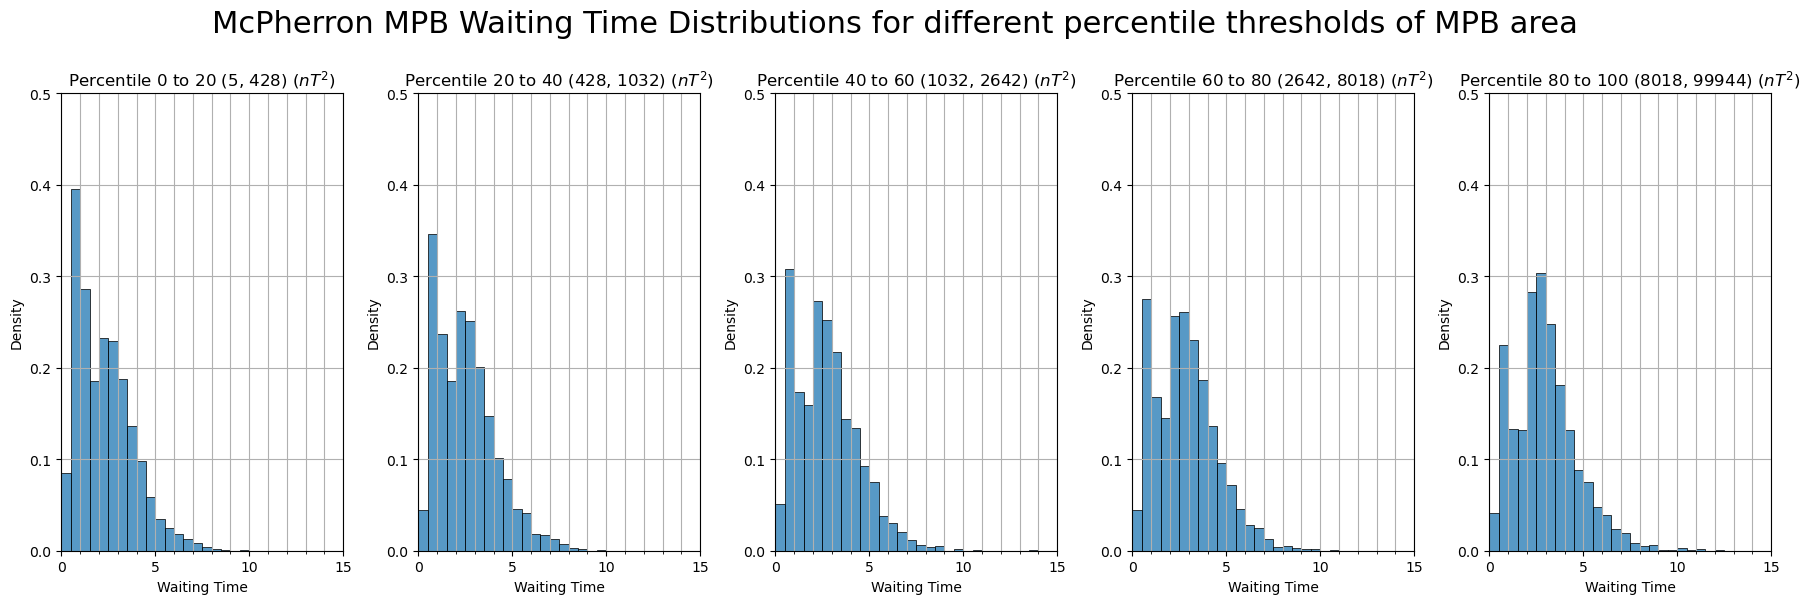

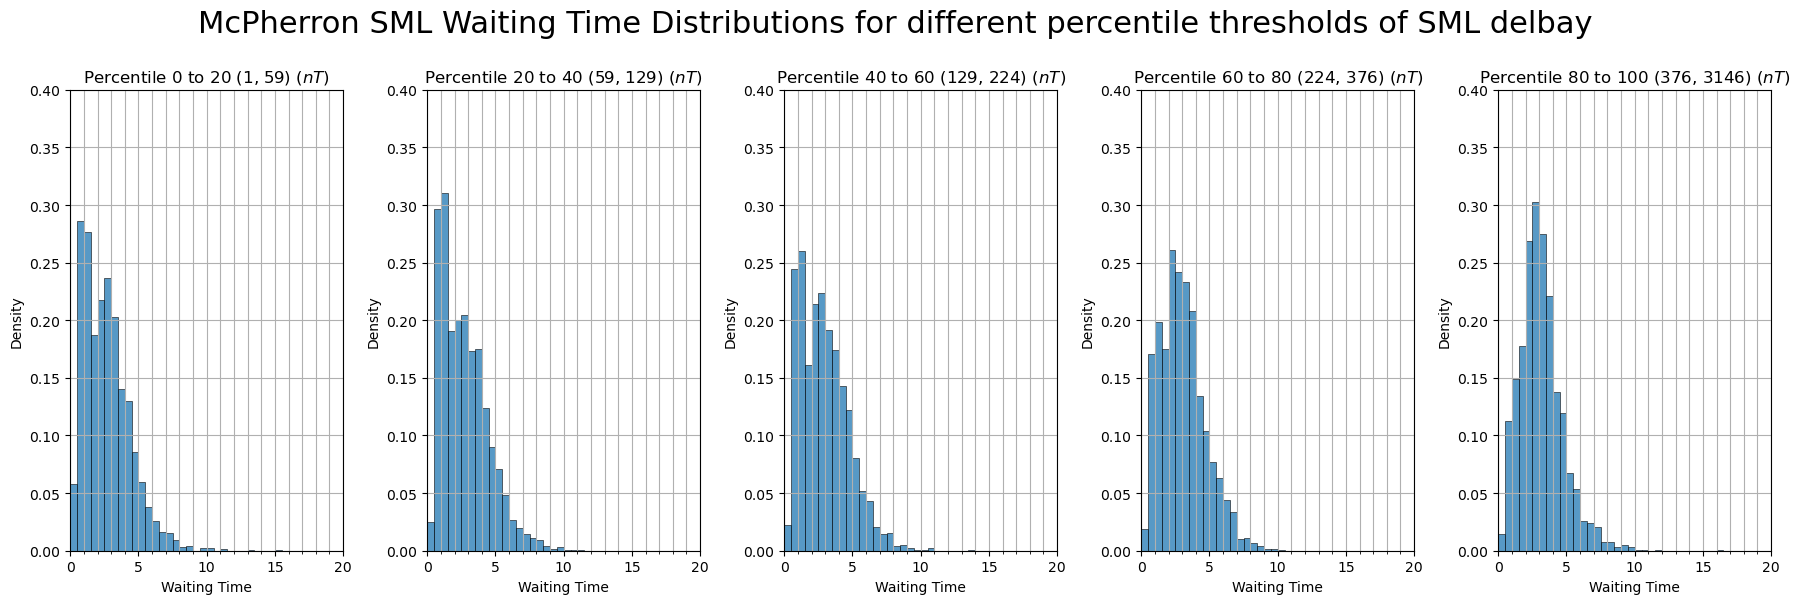

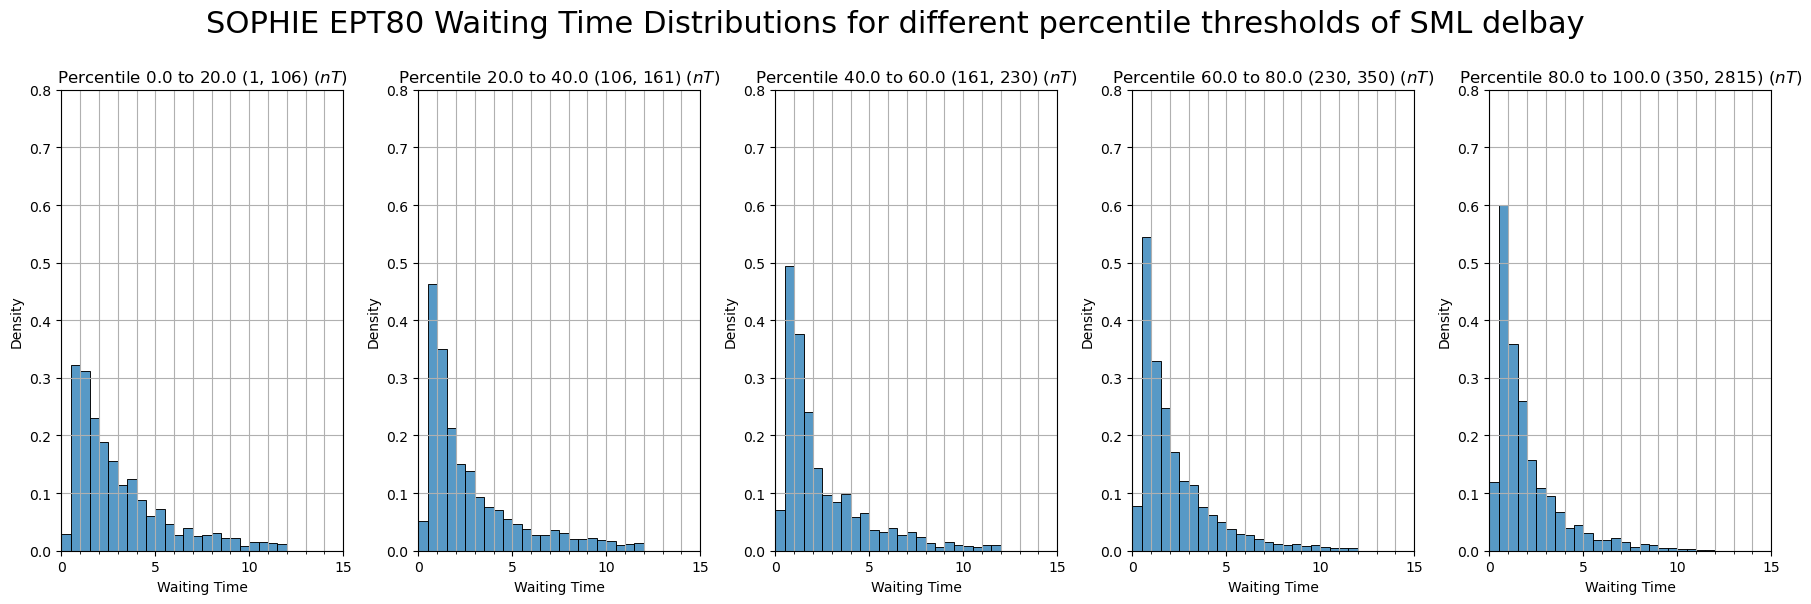

In [12]:
percentiles = np.arange(0, 101, 20)
steps = [np.nanpercentile(mpbwaitingtimedf["Size"], i) for i in percentiles]
fig, axes = plt.subplots(1, 5, figsize=(18, 6))
for i in range(len(steps) - 1):
    sns.histplot(
        mpbwaitingtimedf["Waiting Time"][
            mpbwaitingtimedf["Size"].between(steps[i], steps[i + 1])
        ],
        binrange=[0, 15],
        binwidth=0.5,
        stat="density",
        ax=axes[i],
    )
    axes[i].grid(True, "both")
    axes[i].set_xlim(0, 15)
    axes[i].set_ylim(0, 0.5)
    axes[i].set_title(
        "Percentile {} to {} ({:.0f}, {:.0f}) ($nT^2$)".format(
            percentiles[i], percentiles[i + 1], steps[i], steps[i + 1]
        )
    )
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(1))

fig.suptitle(
    "McPherron MPB Waiting Time Distributions for different percentile thresholds of MPB area",
    y=1,
    fontsize=22,
)
fig.tight_layout()

percentiles = np.arange(0, 101, 20)
steps = [np.percentile(smlwaitingtimedf["Size"], i) for i in percentiles]

fig, axes = plt.subplots(1, 5, figsize=(18, 6))
for i in range(len(steps) - 1):
    sns.histplot(
        smlwaitingtimedf["Waiting Time"][
            smlwaitingtimedf["Size"].between(steps[i], steps[i + 1])
        ],
        binrange=[0, 20],
        binwidth=0.5,
        stat="density",
        ax=axes[i],
    )
    axes[i].grid(True, "both")
    axes[i].set_xlim(0, 20)
    axes[i].set_ylim(0, 0.4)
    axes[i].set_title(
        "Percentile {} to {} ({:.0f}, {:.0f}) ($nT$)".format(
            percentiles[i], percentiles[i + 1], steps[i], steps[i + 1]
        )
    )
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(1))


fig.suptitle(
    "McPherron SML Waiting Time Distributions for different percentile thresholds of SML delbay",
    y=1,
    fontsize=22,
)
fig.tight_layout()


data = sophie80wtdf[sophie80wtdf['Size'].between(0,5000)]
nplots = 5
percentiles = np.arange(0, 101, 100/nplots)
steps = [np.nanpercentile(data["Size"], i) for i in percentiles]

fig, axes = plt.subplots(1, nplots, figsize=(18,6))
for i in range(len(steps) - 1):
    sns.histplot(
        data["Waiting Time"][
            data["Size"].between(steps[i], steps[i + 1])
        ],
        binrange=[0, 12],
        binwidth=.5,
        stat="density",
        ax=axes[i],
    )
    axes[i].grid(True, "both")
    axes[i].set_xlim(0, 15)
    axes[i].set_ylim(0, 0.8)
    axes[i].set_title(
        "Percentile {} to {} ({:.0f}, {:.0f}) ($nT$)".format(
            percentiles[i], percentiles[i + 1], steps[i], steps[i + 1]
        )
    )
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(5))
    axes[i].xaxis.set_minor_locator(ticker.MultipleLocator(1))


fig.suptitle(
    "SOPHIE EPT80 Waiting Time Distributions for different percentile thresholds of SML delbay",
    y=1,
    fontsize=22,
)
fig.tight_layout()

Text(0.5, 0.98, 'SOPHIE EPT80')

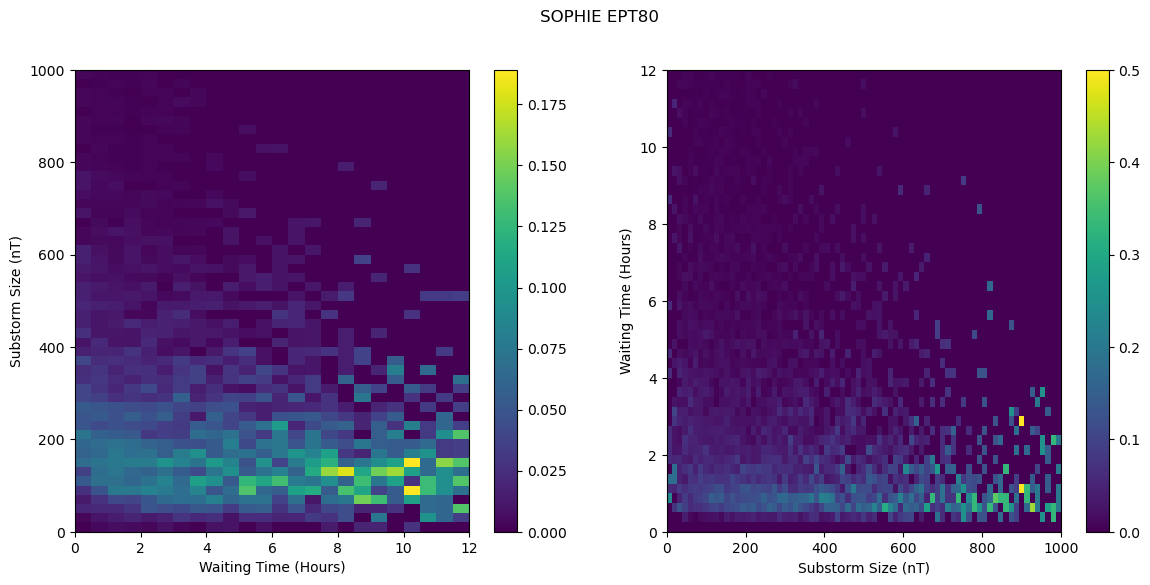

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))


x_edges = np.arange(0,12.5,0.5)
y_edges = np.linspace(0,1000,51)

values = []

for i in range(1,len(x_edges)):
    a = sophie80wtdf['Size'][sophie80wtdf['Waiting Time'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)


X,Y = np.meshgrid(x_edges,y_edges)
plot1 = ax1.pcolormesh(X, Y, values.T)
ax1.set_xlabel("Waiting Time (Hours)")
ax1.set_ylabel("Substorm Size (nT)")
plt.colorbar(plot1,ax=ax1)

x_edges = np.linspace(0,1000,76)
y_edges = np.arange(0,12.25,0.25)

values = []

for i in range(1,len(x_edges)):
    a = sophie80wtdf['Waiting Time'][sophie80wtdf['Size'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)

X,Y = np.meshgrid(x_edges,y_edges)
plot2 = ax2.pcolormesh(X, Y, values.T)
ax2.set_xlabel("Substorm Size (nT)")
ax2.set_ylabel("Waiting Time (Hours)")
plt.colorbar(plot2,ax=ax2)

fig.suptitle('SOPHIE EPT80')


/var/folders/fn/z_9q6pqn37jb1sxy8m9r7bpw0000gn/T/ipykernel_76237/844292495.py:12: RuntimeWarning: invalid value encountered in true_divide
  c = b/np.sum(b)


Text(0.5, 0.98, 'McPherron & Chu MPB')

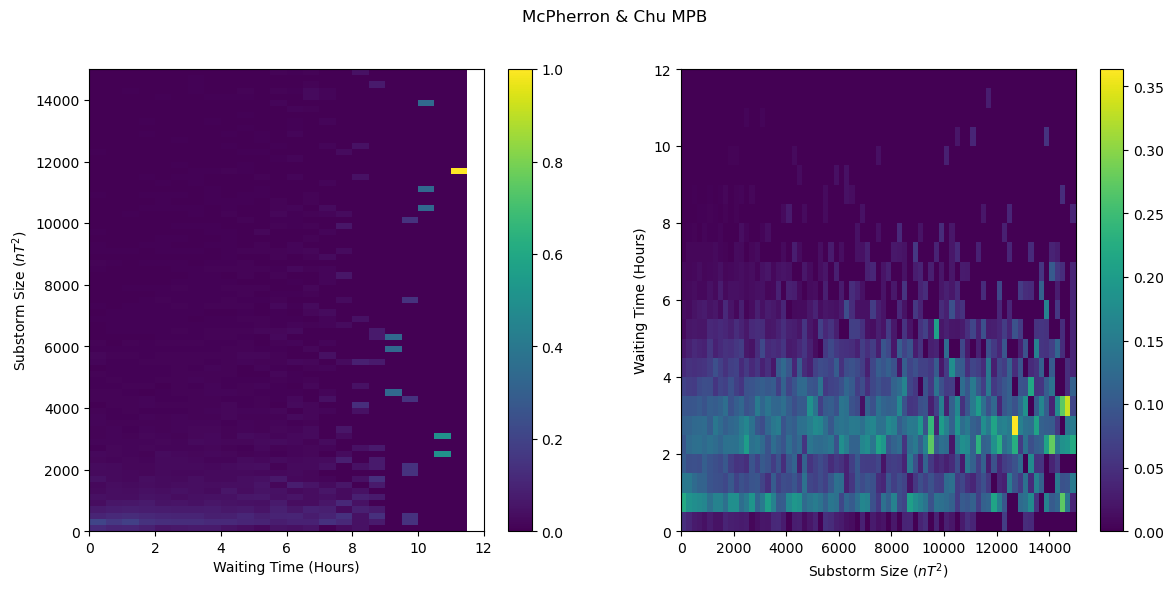

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))


x_edges = np.arange(0,12.5,0.5)
y_edges = np.linspace(0,15000,76)

values = []

for i in range(1,len(x_edges)):
    a = mpbwaitingtimedf['Size'][mpbwaitingtimedf['Waiting Time'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)

X,Y = np.meshgrid(x_edges,y_edges)
plot1 = ax1.pcolormesh(X, Y, values.T)
ax1.set_xlabel("Waiting Time (Hours)")
ax1.set_ylabel("Substorm Size $(nT^2)$")
plt.colorbar(plot1,ax=ax1)
x_edges = np.linspace(0,15000,76)
y_edges = np.arange(0,12.5,0.5)

values = []

for i in range(1,len(x_edges)):
    a = mpbwaitingtimedf['Waiting Time'][mpbwaitingtimedf['Size'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)

X,Y = np.meshgrid(x_edges,y_edges)
plot2 = ax2.pcolormesh(X, Y, values.T)
ax2.set_xlabel("Substorm Size $(nT^2)$")
ax2.set_ylabel("Waiting Time (Hours)")
plt.colorbar(plot2,ax=ax2)

fig.suptitle('McPherron & Chu MPB')

Text(0.5, 0.98, 'McPherron & Chu SML')

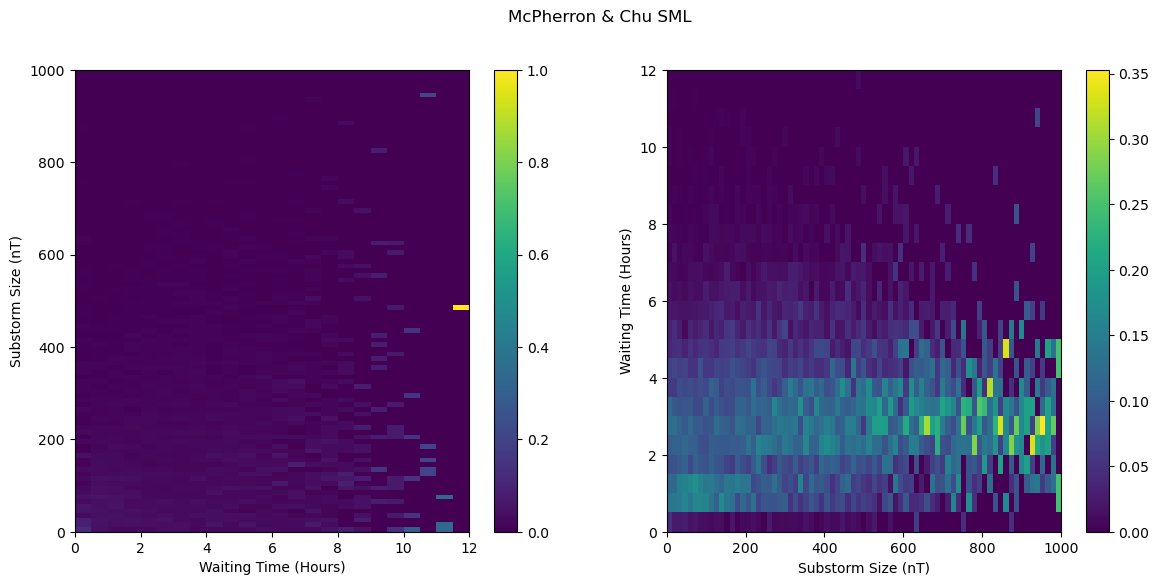

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

x_edges = np.arange(0,12.5,0.5)
y_edges = np.linspace(0,1000,101)

values = []

for i in range(1,len(x_edges)):
    a = smlwaitingtimedf['Size'][smlwaitingtimedf['Waiting Time'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)

X,Y = np.meshgrid(x_edges,y_edges)
plot1 = ax1.pcolormesh(X, Y, values.T)
ax1.set_xlabel("Waiting Time (Hours)")
ax1.set_ylabel("Substorm Size (nT)")
plt.colorbar(plot1,ax=ax1)

x_edges = np.linspace(0,1000,76)
y_edges = np.arange(0,12.5,0.5)

values = []

for i in range(1,len(x_edges)):
    a = smlwaitingtimedf['Waiting Time'][smlwaitingtimedf['Size'].between(x_edges[i-1],x_edges[i])]
    b = np.histogram(a, bins=y_edges)[0]
    c = b/np.sum(b)
    values.append(c)
    
values = np.array(values)


X,Y = np.meshgrid(x_edges,y_edges)
plot2 = ax2.pcolormesh(X, Y, values.T)
ax2.set_xlabel("Substorm Size (nT)")
ax2.set_ylabel("Waiting Time (Hours)")
plt.colorbar(plot2,ax=ax2)

fig.suptitle('McPherron & Chu SML')